# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning I</font>


# Style Transfer

## Introdução

Este Mini-projeto vai utilizar duas imagens como entrada: uma imagem de conteúdo e uma imagem de estilo e então criar uma imagem mista que tenha os contornos da imagem de conteúdo e as cores e a textura da imagem de estilo. Isso é Style Transfer. Como podemos imaginar, esta técnica tem um enorme potencial - dá a todos o poder de produzir obras de arte bonitas, inspiradas em suas pinturas e texturas favoritas. A tecnologia que gera essas imagens também é bastante notável da perspectiva da tecnologia e vale a pena compreendê-la em mais detalhes. Um exemplo de aplicação comercial desta técnica pode ser encontrada aqui: [DeepArt] (http://www.deepart.io)

In [1]:
from IPython.display import Image, display
Image('images/style-transfer.png')

Este Mini-Projeto tem nível avançado e alguns dos conceitos aqui abordados ainda serão estudados ao longo dos demais cursos da Formação IA, incluindo o curso de Visão Computacional e os capítulos sobre CNNs aqui mesmo neste curso. Mas é uma boa oportunidade para começar a se familiarizar com esta técnica e com Deep Learning. O objetivo deste mini-projeto é ser usado como ferramenta de auto-estudo. Quanto mais exposto você estiver a Deep Learning, melhor será seu aprendizado. Leia todos os comentários, execute o código e siga as sugestões ao final deste Notebook. Estude também os arquivos .py que acompanham este Notebook. Recomendamos executar este mini-projeto no servidor da DSA, pois ele computacionalmente intensivo.

A documentação oficial desta técnica pode ser encontrada aqui: https://arxiv.org/abs/1508.06576

## Flowchart

Este fluxograma abaixo mostra aproximadamente a ideia do algoritmo de Transferência de Estilo, embora usemos o modelo VGG-16 que possui muitas camadas, mais do que aqui mostrado.

Duas imagens são inseridas na rede neural: uma imagem de conteúdo e uma imagem de estilo. Desejamos gerar a imagem mista que tem os contornos da imagem de conteúdo e as cores e a textura da imagem de estilo. Fazemos isso criando várias funções de perda que podem ser otimizadas.

A função de perda para a imagem de conteúdo tenta minimizar a diferença entre os recursos que são ativados para a imagem de conteúdo e para a imagem mista, em uma ou mais camadas na rede. Isso faz com que os contornos da imagem mista se assemelhem aos da imagem de conteúdo.

Usaremos o TensorFlow para derivar automaticamente o gradiente para essas funções de perda. O gradiente é então usado para atualizar a imagem mista. Este procedimento é repetido várias vezes até ficar satisfeito com a imagem resultante.

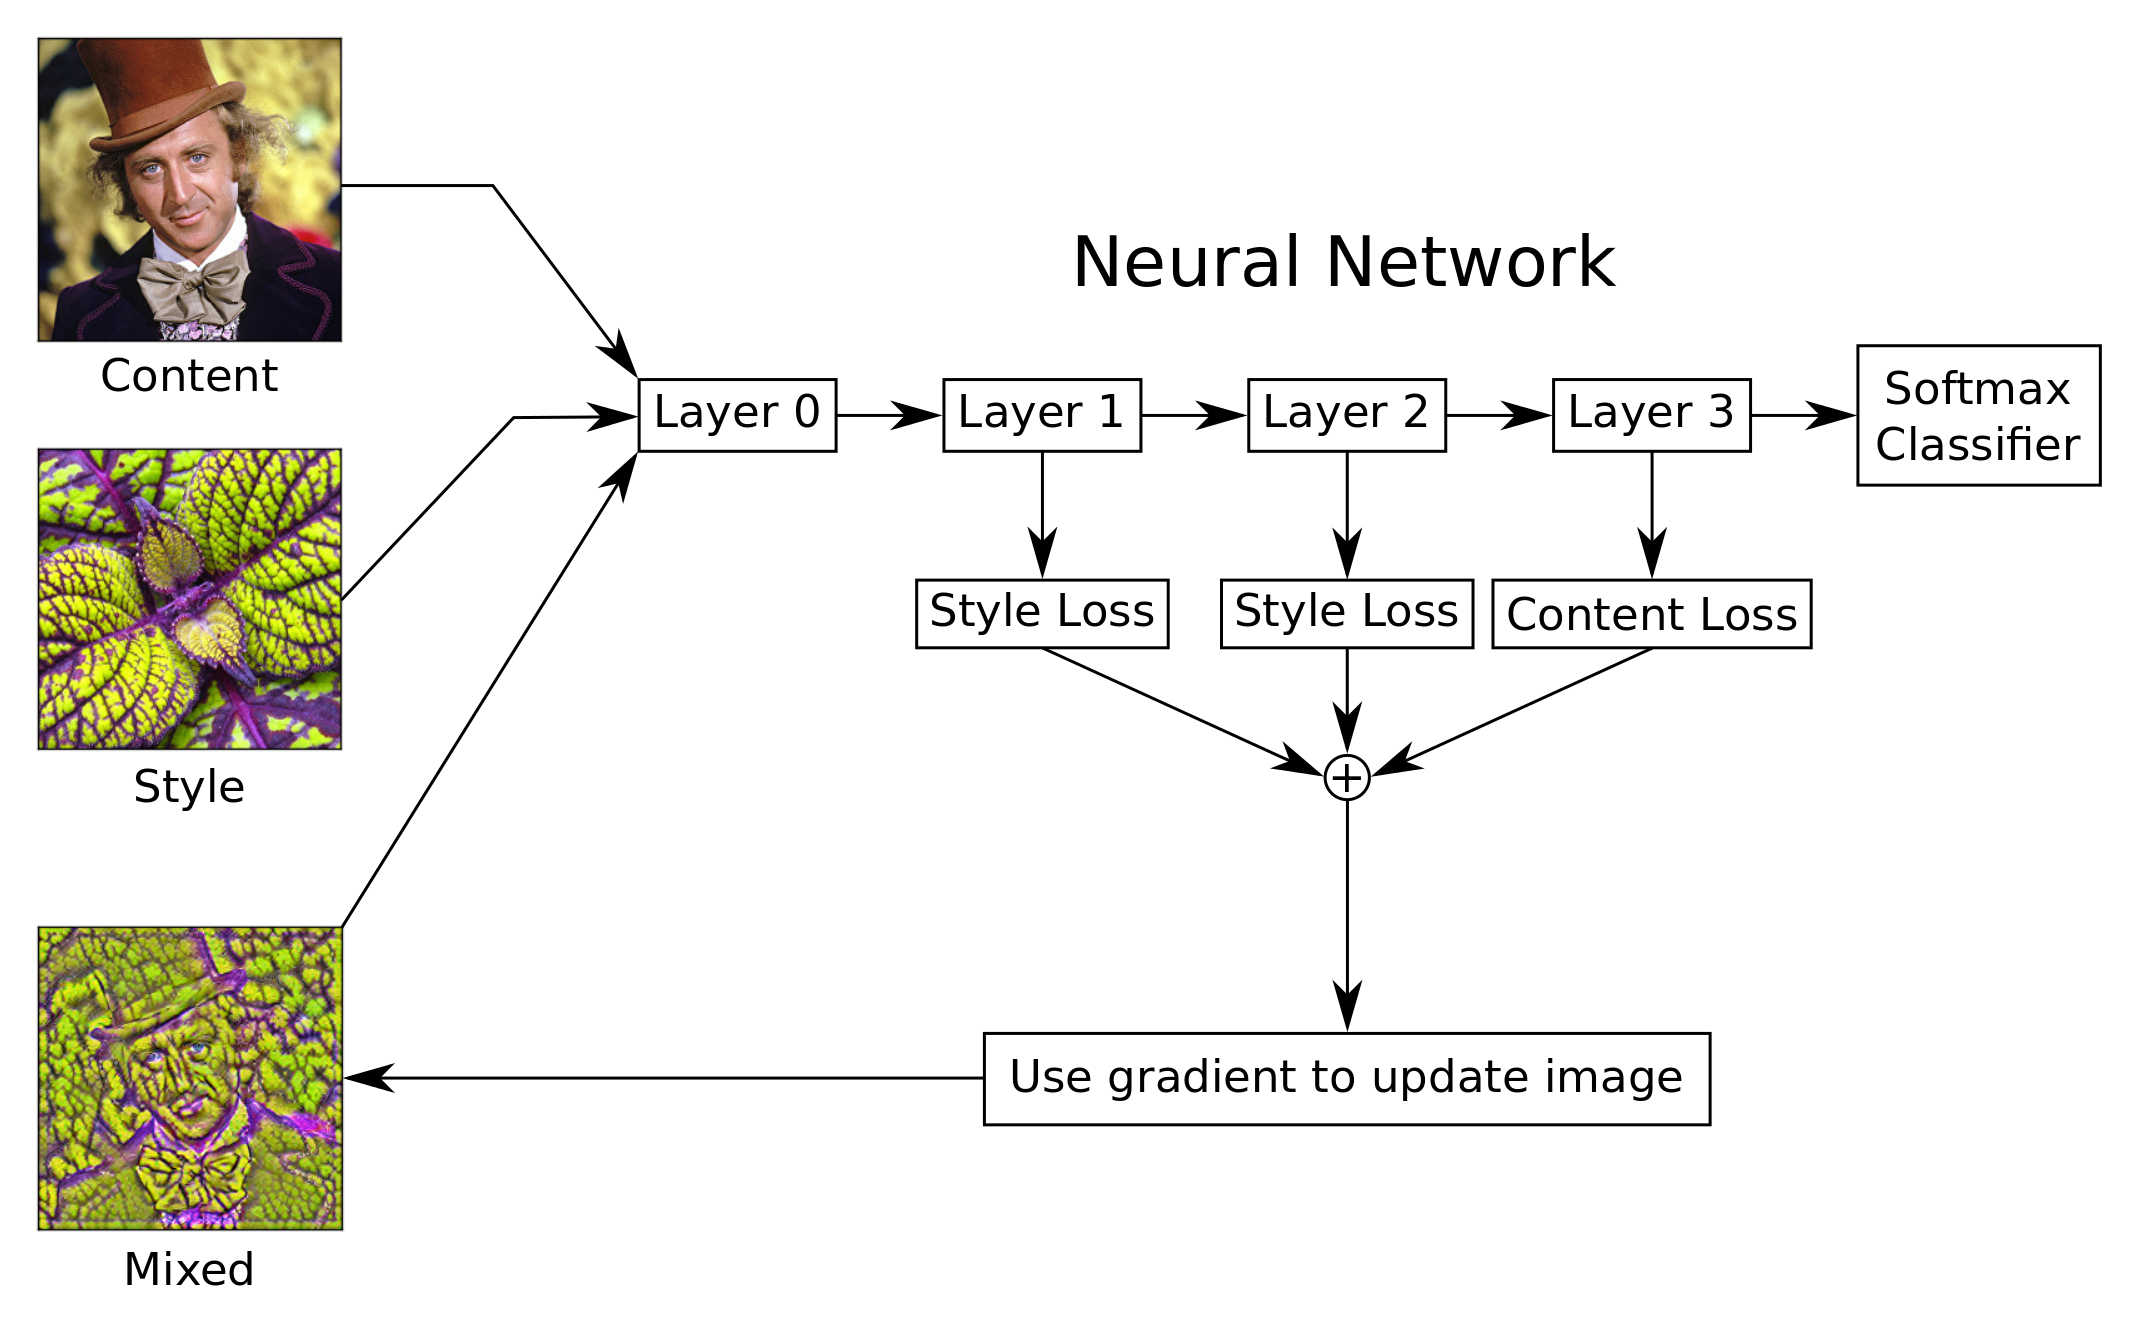

In [2]:
from IPython.display import Image, display
Image('images/style_transfer_flowchart.png')

## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

In [4]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

Usamos a versão Python 3.7.0 (Anaconda) e TensorFlow:

In [5]:
tf.__version__

'2.1.0'

## VGG-16 Model

O [documento original] (https://arxiv.org/abs/1508.06576) da transferência de estilo usou a rede neural convolutiva VGG-19. Mas os modelos pré-treinados VGG-19 para TensorFlow não pareciam adequados para este mini-projeto por diferentes motivos. Em vez disso, usaremos o modelo VGG-16, que pode ser facilmente carregado no TensorFlow. O arquivo anexo vgg16.py contém o código necessário para download deste modelo pré-treinado!

O modelo VGG16 é uma Deep Neural Network que já foi treinada para classificar imagens em 1000 categorias diferentes. Quando você cria uma nova instância desta classe, o modelo VGG16 será carregado e pode ser usado imediatamente sem treinamento. No Capítulo 6 você encontra mais detalhes sobre o VGG16.

In [6]:
import vgg16

O modelo VGG-16 é baixado da internet. Este é o diretório padrão onde salvar os arquivos de dados. O diretório será criado se ele não existir: vgg16.data_dir = 'vgg16/'

Download dos dados para o modelo VGG-16 se ele ainda não existir no diretório.

** AVISO: são 550 MB! **

In [7]:
vgg16.maybe_download()

Os dados aparentemente já foram baixados e descompactados.


## Funções de Ajuda Para Manipulação de Imagem

Essa função carrega uma imagem e a retorna como uma série numerica de pontos flutuantes. A imagem pode ser redimensionada automaticamente para que a maior, da altura ou largura, seja igual a `max_size`.

In [8]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calcula o fator de escala apropriado, garantindo uma altura e largura máxima, mantendo proporção entre eles.
        factor = max_size / np.max(image.size)

        # Dimensiona a altura e a largura da imagem.
        size = np.array(image.size) * factor

        # O tamanho agora é de ponto flutuante porque foi dimensionado.
        # Mas PIL requer que o tamanho seja inteiro.
        size = size.astype(int)

        # Redimensiona a imagem.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Converte em array numpy de ponto flutuante.
    return np.float32(image)

Salva a imagem como um arquivo jpeg. A imagem é dada como uma matriz numpy com valores de pixel entre 0 e 255.

In [9]:
def save_image(image, filename):
    # Certifique-se de que os valores de pixels estejam entre 0 e 255.
    image = np.clip(image, 0.0, 255.0)

    # Converte em bytes.
    image = image.astype(np.uint8)

    # Grave o arquivo de imagem no formato jpeg.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

Esta função representa uma imagem grande. A imagem é dada como uma matriz numpy com valores de pixel entre 0 e 255.

In [10]:
def plot_image_big(image):
    image = np.clip(image, 0.0, 255.0)

    image = image.astype(np.uint8)

    # Converte em uma imagem PIL e visualiza
    display(PIL.Image.fromarray(image))

Esta função gera o plot das imagens de conteúdo, mixadas e de estilo.

In [11]:
def plot_images(content_image, style_image, mixed_image):
    # Cria figura com sub-parcelas.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Ajusta o espaçamento vertical.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Usa a interpolação para suavizar os pixels
    smooth = True

    # Tipos de interpolação
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot da imagem do conteúdo.
    # Note que os valores de pixel são normalizados para o intervalo [0.0, 1.0], dividindo-se com 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot da imagem mista.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot da imagem estilo
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remova os ticks de todas os plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Certifique-se de que o plot seja mostrado corretamente com múltiplos lotes em uma única célula do Notebook.
    plt.show()

## Loss Functions

Essas funções auxiliares criam as funções de perda usadas na otimização com TensorFlow.

Esta função cria uma operação TensorFlow para calcular o erro quadrático médio entre os dois tensores de entrada.

In [12]:
def mean_squared_error(a, b):
    return tf.reduce_mean(input_tensor=tf.square(a - b))

Esta função cria a função de perda para a imagem de conteúdo. É o erro quadrado médio das ativações de recursos nas camadas dadas no modelo, entre a imagem de conteúdo e a imagem mista. Quando esta perda de conteúdo é minimizada, significa, portanto, que a imagem mista possui ativações de recursos nas camadas dadas que são muito semelhantes às ativações da imagem de conteúdo. Dependendo das camadas que você selecionar, isso deve transferir os contornos da imagem de conteúdo para a imagem mista.

In [13]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Cria a função de perda para a imagem de conteúdo.

    Parâmetros:

        session: uma sessão TensorFlow aberta para executar o grafo do modelo.
        model: o modelo, ou seja, uma instância da classe VGG16.
        content_image: Numpy float array com a imagem de conteúdo.
        layer_ids: lista de identificação de inteiros para as camadas a serem usadas no modelo.
    """

    # Cria um feed-dict com a imagem do conteúdo.
    feed_dict = model.create_feed_dict(image=content_image)

    # Obtém referências aos tensores para as camadas fornecidas.
    layers = model.get_layer_tensors(layer_ids)

    # Calcula os valores de saída dessas camadas quando alimentando a imagem do conteúdo para o modelo.
    values = session.run(layers, feed_dict=feed_dict)

    # Define o grafo do modelo como o padrão para que possamos adicionar
    # nós computacionais. Nem sempre é claro
    # quando isso é necessário no TensorFlow, mas se você
    # quiser reutilizar este código, então pode ser necessário.
    with model.graph.as_default():
        # Inicializa uma lista vazia de funções de perda.
        layer_losses = []

        # Para cada camada e seus valores correspondentes na imagem de conteúdo.
        for value, layer in zip(values, layers):
            # Estes são os valores que são calculados para esta camada no modelo ao inserir a imagem de conteúdo.
            # Garantimos que é uma constante, usando const - embora isso possa ser feito automaticamente pela TensorFlow.
            value_const = tf.constant(value)

            # A função de perda para esta camada é o erro quadrado médio entre os valores de camada
            # ao inserir as imagens de conteúdo e mixadas.
            # Note que a imagem mista não é calculada ainda, estamos apenas criando as operações
            # para calcular o MSE entre esses dois.
            loss = mean_squared_error(layer, value_const)

            # Adiciona a função de perda para esta camada na lista de funções de perda.
            layer_losses.append(loss)

        # A perda combinada para todas as camadas é apenas a média.
        # As funções de perda podem ser ponderadas de forma diferente para
        # em cada camada. Você pode tentar e ver o que acontece.
        total_loss = tf.reduce_mean(input_tensor=layer_losses)

    return total_loss

Faremos algo semelhante para as camadas de estilo, mas agora queremos medir quais recursos na camada de estilo ativam simultaneamente para a imagem de estilo e, em seguida, copiar este padrão de ativação para a imagem mista.

Uma maneira de fazer isso é calcular a chamada "Gram-matrix" para a saída dos tensores pelas camadas de estilo. A Gram-matrix é essencialmente apenas uma matriz de produtos de ponto (dot product) para os vetores das ativações de recursos de uma camada de estilo.

Se uma entrada na Gram-matrix tiver um valor próximo a zero, isso significa que os dois recursos na camada fornecida não são ativados simultaneamente para a imagem de estilo dada. E, vice-versa, se uma entrada na Gram-matrix tiver um grande valor, significa que os dois recursos ativados simultaneamente para o estilo-imagem fornecido. Em seguida, tentaremos criar uma imagem mista que reproduza esse padrão de ativação da imagem de estilo.

Esta é a função auxiliar para calcular a Gram-matrix de uma saída de tensor por uma camada convolucional na rede neural. A função de perda real é criada mais adiante.

In [14]:
def gram_matrix(tensor):
    shape = tensor.get_shape()

    # Obter o número de canais de recursos para o tensor de entrada,
    # que se supõe que seja de uma camada convolucional com 4-dim.
    num_channels = int(shape[3])

    # Remodelando o tensor e por isso é uma matriz de 2-dim. Isto essencialmente
    # aplica o conteúdo de cada canal de recurso.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])

    # Calcula a Gram-matrix como o produto-matriz da matriz 2-dim com ela mesma. Isso calcula o
    # dot product de todas as combinações dos canais de recursos.
    gram = tf.matmul(tf.transpose(a=matrix), matrix)

    return gram

A próxima função cria a função de perda para a imagem de estilo. É bastante semelhante ao `create_content_loss()` acima, exceto que calculamos o erro quadrático médio para a Gram-matrix em vez das saídas dos tensores das camadas.

In [15]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Cria a função de perda para a imagem de estilo.

    Parâmetros:

     session: uma sessão TensorFlow aberta para executar o gráfico do modelo.
     model: o modelo, isto é, uma instância da classe VGG16.
     style_image: Numpy float array com a imagem de estilo.
     layer_ids: lista de identificação de inteiros para as camadas a serem usadas no modelo.
    """

    # Cria um feed-dict com a imagem de estilo.
    feed_dict = model.create_feed_dict(image=style_image)

    # Obtém referências aos tensores para as camadas fornecidas.
    layers = model.get_layer_tensors(layer_ids)

    # Define o grafo do modelo como o padrão para que possamos adicionar nós computacionais a ele.
    with model.graph.as_default():
        # Constrói as operações TensorFlow para calcular as Gram-matrizes para cada uma das camadas.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Executa a sessão
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Inicializa uma lista vazia de funções de perda.
        layer_losses = []

        # Para cada camada Gram-matrix e seus valores correspondentes
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)

        # A perda combinada para todas as camadas é apenas a média.
        # As funções de perda podem ser ponderadas de forma diferente para cada camada.
        total_loss = tf.reduce_mean(input_tensor=layer_losses)

    return total_loss

Isso cria a função de perda para desativar a imagem mista. O algoritmo é denominado [Total Variation Denoising] (https://en.wikipedia.org/wiki/Total_variation_denoising) e essencialmente apenas desloca a imagem um pixel nos eixos x e y, calcula a diferença a partir da imagem original, recebe o valor absoluto para garantir que a diferença é um número positivo, e calcula a soma sobre todos os pixels na imagem. Isso cria uma função de perda que pode ser minimizada de modo a suprimir um pouco do ruído na imagem.

In [16]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(input_tensor=tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(input_tensor=tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

## Algotimos Style-Transfer 

Este é o principal algoritmo de otimização para o algoritmo Style-Transfer. É basicamente apenas uma descida do gradiente nas funções de perda definidas acima.

Este algoritmo também usa a normalização das funções de perda. Em cada iteração da otimização, os valores de perda são ajustados para que cada um deles seja igual a um. Isso permite que o usuário defina os pesos de perda independentemente das camadas de estilo e conteúdo escolhidas. Ele também adapta a ponderação durante a otimização para garantir que a proporção desejada entre estilo, conteúdo e desativação seja preservada.

In [17]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Usa a descida do gradiente para encontrar uma imagem que minimize a
    perda de funções das camadas de conteúdo e camadas de estilo. este
    deve resultar em uma imagem mista que se assemelha aos contornos
    da imagem do conteúdo e se assemelha às cores e texturas
    da imagem de estilo.

    Parâmetros:
     content_image: Numpy 3-dim float-array com a imagem de conteúdo.
     style_image: Numpy 3-dim float-array com a imagem de estilo.
     content_layer_ids: Lista de inteiros que identificam as camadas de conteúdo.
     style_layer_ids: Lista de inteiros que identificam as camadas de estilo.
     weight_content: Peso para a função de perda de conteúdo.
     weight_style: peso para a função de perda de estilo.
     weight_denoise: Peso para a função de perda de energia.
     num_iterations: Número de iterações de otimização a serem executadas.
     step_size: Step-size para o gradiente em cada iteração.
    """

    # Cria uma instância do modelo VGG16.
    # Isso é feito em cada chamada desta função, porque iremos adicionar
    # operações para o grafo fazendo com que ele possa crescer muito
    # e ficar sem RAM se continuar usando a mesma instância.
    model = vgg16.VGG16()

    # Cria uma TensorFlow-session.
    session = tf.compat.v1.InteractiveSession(graph=model.graph)

    # Imprime os nomes das camadas de conteúdo.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Imprime os nomes das camadas de estilo.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Cria uma função de perda para as camadas de conteúdo e imagem.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Cria a função de perda para as camadas de estilo e a imagem.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)

    # Cria a função de perda para o desmembramento da imagem mista.
    loss_denoise = create_denoise_loss(model)

    # Cria variáveis TensorFlow para ajustar os valores das  funções de perda. Isso é explicado abaixo.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Inicializa os valores de ajuste para as funções de perda.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Cria operações TensorFlow para atualizar os valores de ajuste.
    # Estes são basicamente apenas os valores recíprocos das funções de perda,
    # com um pequeno valor 1e-10 adicionado para evitar a possibilidade de divisão por zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # Esta é a função de perda ponderada que minimizaremos para gerar a imagem mista.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Usamos o TensorFlow para obter a função matemática para o
    # Gradiente da função de perda combinada em relação a imagem de entrada.
    gradient = tf.gradients(ys=loss_combined, xs=model.input)

    # Lista de tensores que vamos rodar em cada iteração de otimização.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # A imagem mista é inicializada com ruído aleatório.
    # É do mesmo tamanho que a imagem de conteúdo.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Usa TensorFlow para calcular o valor do
        # Gradiente, bem como atualizar os valores de ajuste.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduzir a dimensionalidade do gradiente.
        grad = np.squeeze(grad)

        # Dimensiona o tamanho do passo de acordo com os valores de gradiente.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Atualiza a imagem seguindo o gradiente.
        mixed_image -= grad * step_size_scaled

        # Certifique-se de que a imagem tenha valores de pixels válidos entre 0 e 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print
        print(". ", end="")

        # Display status
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)

    print()
    print("Final image:")
    plot_image_big(mixed_image)

    session.close()

    return mixed_image

## Executando o Style Transfer

Este exemplo mostra como transferir o estilo de várias imagens para um retrato.

Primeiro, carregamos a imagem de conteúdo que tem os contornos gerais que queremos na imagem mista.

In [18]:
content_filename = 'images/willy_wonka_old.jpg'
content_image = load_image(content_filename, max_size=None)

Em seguida, carregamos a imagem de estilo que tem as cores e texturas que queremos na imagem mista.

In [19]:
style_filename = 'images/style1.jpg'
style_image = load_image(style_filename, max_size=300)

Em seguida, definimos uma lista de inteiros que identificam as camadas na rede neural que queremos usar para combinar a imagem de conteúdo. Estes são índices nas camadas na rede neural. Para o modelo VGG16, a 5ª camada (índice 4) parece funcionar bem como a única camada de conteúdo.

In [20]:
content_layer_ids = [4]

Então, nós definimos outra lista de inteiros para as camadas de estilo.

In [21]:
# O modelo VGG16 possui 13 camadas convolutivas.
# Isso seleciona todas essas camadas como as camadas de estilo.
style_layer_ids = list(range(13))

# Você também pode selecionar um subconjunto das camadas, exemplo:
# style_layer_ids = [1, 2, 3, 4]

Agora, execute a transferência de estilo. Isso cria automaticamente as funções de perda apropriadas para as camadas de estilo e conteúdo e, em seguida, executa uma série de iterações de otimização. Isso irá gradualmente criar uma imagem mista que tenha contornos semelhantes à da imagem de conteúdo, sendo as cores e as texturas similares à imagem de estilo.

Isso pode ser muito lento em uma CPU!

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 5.18e-11, Style: 1.82e-28, Denoise: 5.61e-06


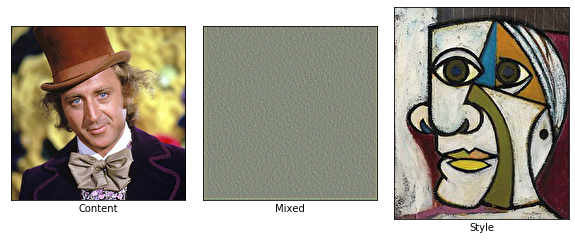

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 4.40e-11, Style: 2.05e-27, Denoise: 1.43e-07


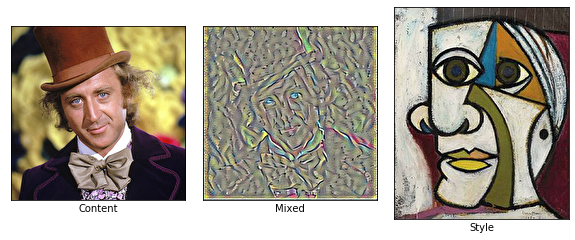

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 4.34e-11, Style: 1.92e-27, Denoise: 1.25e-07


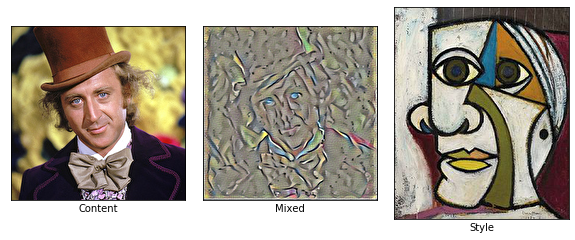

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 4.46e-11, Style: 2.38e-27, Denoise: 1.29e-07


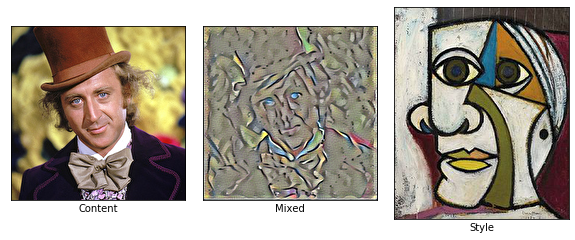

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 4.51e-11, Style: 2.59e-27, Denoise: 1.30e-07


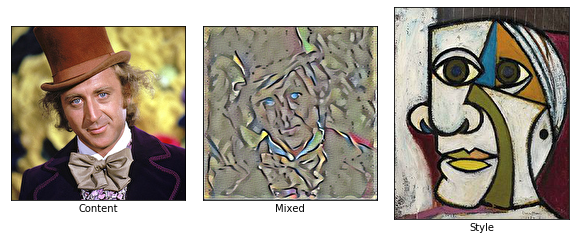

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 4.57e-11, Style: 2.84e-27, Denoise: 1.30e-07


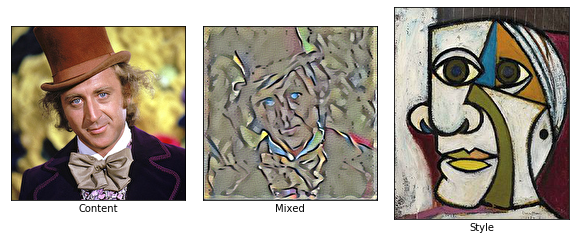

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 4.54e-11, Style: 1.58e-27, Denoise: 1.31e-07


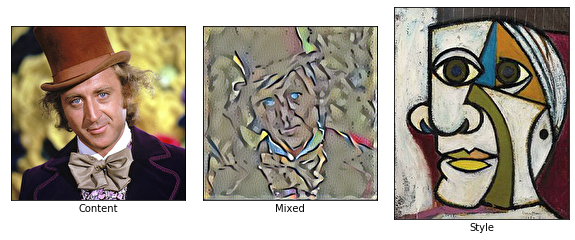


Final image:


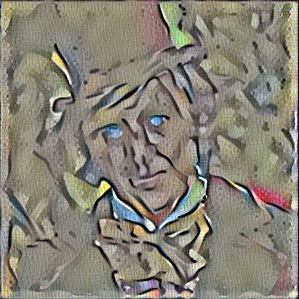

CPU times: user 5min 24s, sys: 20.4 s, total: 5min 44s
Wall time: 41.8 s


In [22]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)

## Conclusão

Este mini-projeto mostrou a ideia básica de usar redes neurais para combinar o conteúdo e o estilo de duas imagens. Os resultados não foram tão bonitos como alguns dos sistemas disponíveis comercialmente, como [DeepArt] (http://www.deepart.io) que foi desenvolvido por alguns dos pioneiros nessas técnicas. O motivo não está claro. Talvez simplesmente precisemos de mais poder computacional para que possamos realizar mais iterações de otimização com tamanhos pequenos e imagens de resolução superior. Ou talvez precisemos usar um método de otimização mais sofisticado. As sugestões abaixo dão sugestões que podem melhorar a qualidade e você é encorajado a experimentá-los.

## Sugestões

Estas são algumas sugestões para exercícios que podem ajudar a melhorar suas habilidades com TensorFlow. É importante obter experiência prática com o TensorFlow para aprender a usá-lo corretamente.

Você pode querer fazer backup desse Notebook e dos outros arquivos antes de fazer qualquer alteração.

Exercícios:

* Tente usar outras imagens. Várias imagens de estilo estão incluídas em anexo. Você também pode tentar usar suas próprias imagens.
* Experimente mais iterações de otimização (por exemplo 1000-5000) e tamanhos de passo menores (por exemplo, 1.0-3.0). Isso melhora a qualidade?
* Alterar os pesos para o estilo, conteúdo e desativação.
* Tente e comece a otimização a partir da imagem de conteúdo ou estilo, ou talvez seja uma média dos dois. Você também pode misturar um pouco de ruído.
* Tente alterar a resolução das imagens de estilo e conteúdo. Você pode usar o argumento `max_size` para a função` load_image () `para redimensionar as imagens. Como isso afeta o resultado?
* Tente usar outras camadas no modelo VGG-16.
* Use pesos constantes ao longo da otimização. Isso afeta o resultado?
* Use pesos diferentes para as camadas de estilo. Tente também ajustar automaticamente esses pesos, como os outros pesos de perda.
* Use o otimizador ADAM do TensorFlow em vez da descida básica do gradiente.
* Use o otimizador L-BFGS. Isso não está atualmente implementado no TensorFlow. Você consegue que o SciPy trabalhe com o algoritmo de transferência de estilo? Isso melhora o resultado?
* Explique a um amigo como o programa funciona.

# Fim